In [81]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
np.random.seed(7)

In [3]:
df_features = pickle.load(open('../df_features.pkl', 'rb'))
df_features['no_sentences'] = df_features.tokens.map(lambda x: sum(1 for _ in x.sents))
df_features.head()

,subject,joined,student,tokens,lemmas,no_sentences
0,nursing,Total Word Count: This report has been prepare...,student,"(Total, Word, Count, :, This, report, has, bee...",total word count : this report have be prepare...,82
1,nursing,"Leadership has been described as ""a relational...",student,"(Leadership, has, been, described, as, "", a, r...","leadership have be describe as "" a relational ...",179
2,nursing,Depression among pregnant adolescents as well ...,student,"(Depression, among, pregnant, adolescents, as,...",depression among pregnant adolescent as well a...,129
3,nursing,"Davidson, E., Daly, J., Brady, R. & Higgins, P...",student,"(Davidson, ,, E., ,, Daly, ,, J., ,, Brady, ,,...","davidson , e. , daly , j. , brady , r. & higgi...",80
4,nursing,Idiopathic pulmonary fibrosis (IPF) is a devas...,student,"(Idiopathic, pulmonary, fibrosis, (, IPF, ), i...",idiopathic pulmonary fibrosis ( ipf ) be a dev...,185


In [4]:
rnn_df = pd.DataFrame(columns=['paragraph', 'target', 'doc_no', 'seq_len'])
max_para_length = 500
j = 0
for i, doc in enumerate(df_features.tokens):
    
    # Skip the doc if it is really short
    if df_features.no_sentences[i] < 3:
        print('skipped')
        continue
        
    # Make a new paragraph
    paragraph = []
    
    for span in doc:
        # If an additional span will fit, add it
        if (len(paragraph) + len(span)) < max_para_length:
            paragraph.append(span)
        
        # If it won't fit, add what we got into the dataframe and start
        # over, starting with the span we are looking at
        else:
            rnn_df.loc[j, 'paragraph'] = paragraph
            rnn_df.loc[j, 'target'] = df_features.student[i]
            rnn_df.loc[j, 'doc_no'] = i
            rnn_df.loc[j, 'seq_len'] = len(paragraph)
            paragraph = [span]
            j += 1
        
    # Pin whatever is left over into the dataframe
    rnn_df.loc[j, 'paragraph'] = paragraph
    rnn_df.loc[j, 'target'] = df_features.student[i]
    rnn_df.loc[j, 'doc_no'] = i
    rnn_df.loc[j, 'seq_len'] = len(paragraph)
    j += 1
        
    if i % 100 == 0:
        print('Working on document: {}'.format(i))
        
rnn_df.reset_index(inplace=True, drop=True)
print('Total no. of paragraphs in rnn_df:', len(rnn_df))
rnn_df.head()

Working on document: 0
Working on document: 100
Working on document: 200
Working on document: 300
Working on document: 400
Working on document: 500
Working on document: 600
Working on document: 700
Total no. of paragraphs in rnn_df: 4211


,paragraph,target,doc_no,seq_len
0,"[Total, Word, Count, :, This, report, has, bee...",student,0,488
1,"[Organisation, ,, 2009, ), ”, ., It, inspect, ...",student,0,486
2,"[prolymphocitic, leukemia, ), and, its, signif...",student,0,494
3,"[occurred, ., More, effective, defence, has, b...",student,0,118
4,"[Leadership, has, been, described, as, "", a, r...",student,1,493


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer

'''
We will use this vectorizer to build a vocab from our texts. It should be noted that
'''
vectorizer = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize
                            ).fit(df_features.joined)
print('Number of different words in corpus:', len(vectorizer.vocabulary_))

Number of different words in corpus: 58493


In [6]:
rnn_features = pd.DataFrame(columns=[])

translate_dict = vectorizer.vocabulary_
vocab_length = len(translate_dict)

# Adding a few unicode strings to our dict
translate_dict[u"\u2019s"] = vocab_length  + 1      # Curly single quote, 's
translate_dict[u"\u00B0"] = vocab_length   + 2      # Degree, as in celsius
translate_dict[u"n\u2019t"] = vocab_length + 3      # n't
translate_dict[u"\u0022"] = vocab_length   + 4      # double straight quote "
translate_dict[u"\u2019ve"] = vocab_length + 5      # 've
translate_dict[u"\u2019re"] = vocab_length + 6      # 're
translate_dict[u"\u2019ll"] = vocab_length + 7      # 'll
translate_dict[u"\u2019d"] = vocab_length  + 8      # 'd




for i, paragraph in enumerate(rnn_df.paragraph):
    paragraph_length = len(paragraph)
    for j in range(max_para_length+1):
        if j < paragraph_length:
            try:
                rnn_features.loc[i, j] = translate_dict[paragraph[j].lower_]
            except:
                if len(paragraph[j]) > 10:
                    rnn_features.loc[i, j] = None
                else:
                    rnn_features.loc[i, j] = vocab_length + 9
        elif j <= max_para_length-1:
            rnn_features.loc[i, j] = 0
        else:
            rnn_features.loc[i, j] = rnn_df.doc_no[i]
            rnn_features.loc[i, j+1] = rnn_df.target[i]
            rnn_features.loc[i, j+2] = rnn_df.seq_len[i]
    if i % 500 == 0:
        print('Working on row: {}'.format(i))

rnn_features.rename({max_para_length:'doc_no', max_para_length+1:'target', 
                     max_para_length+2:'seq_len'}, axis=1, inplace=True)
rnn_features.target = rnn_features.target.map(lambda x: 0 if x=='student' else 1)
print('Total sentences:', len(rnn_features))
rnn_features.dropna(inplace=True)
rnn_features.reset_index(inplace=True, drop=True)
print('Usable sentences:', len(rnn_features))
rnn_features.head()

Working on row: 0
Working on row: 500
Working on row: 1000
Working on row: 1500
Working on row: 2000
Working on row: 2500
Working on row: 3000
Working on row: 3500
Working on row: 4000
Total sentences: 4211
Usable sentences: 3267


,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,doc_no,target,seq_len
0,53832.0,57582.0,16771.0,6446.0,53276.0,45952.0,26995.0,10833.0,42962.0,24320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,488.0
1,39311.0,763.0,3357.0,726.0,58429.0,879.0,30953.0,30025.0,53022.0,45631.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,486.0
2,43573.0,33051.0,726.0,8514.0,30991.0,49311.0,29145.0,13846.0,38775.0,33206.0,...,54382.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,494.0
3,38718.0,879.0,36490.0,20923.0,18081.0,26995.0,10833.0,45117.0,53624.0,21734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,118.0
4,32758.0,26995.0,10833.0,18607.0,9411.0,58497.0,6541.0,45626.0,43350.0,29145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,493.0


In [50]:
from sklearn.model_selection import train_test_split
# We are only going to keep the top 10000 words
X_train, X_test, y_train, y_test = train_test_split(rnn_features.iloc[:, :max_para_length],
                                                    rnn_features.target, test_size=0.2, stratify=rnn_features.target)

In [51]:
X_train = sequence.pad_sequences(X_train.as_matrix(), maxlen=max_para_length)
X_test = sequence.pad_sequences(X_test.as_matrix(), maxlen=max_para_length)

In [52]:
rnn_features.target.value_counts()

0    2975
1     292
Name: target, dtype: int64

In [72]:
class_weight = {0: 1.,
                1: 10.1}

In [94]:
from keras import optimizers

# set some parameters
top_words = 7000
embedding_vecor_length = 64

# Create and add to model
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_para_length))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

#Compile model, print summary, and fit
adam = optimizers.Adam(decay=0.95)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=7, batch_size=64, class_weight=class_weight)
plt.plot

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 500, 64)           448000    
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 500, 32)           6176      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 250, 32)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
__________

<function matplotlib.pyplot.plot>

Accuracy: 72.17%


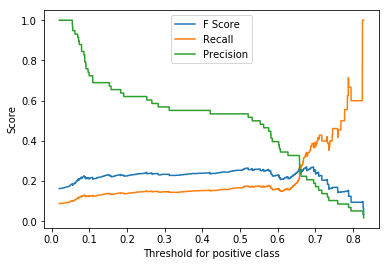

In [91]:
from sklearn.metrics import precision_recall_fscore_support

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

y_pred = model.predict(X_test)

pred_min, pred_max = y_pred.min(), y_pred.max()
scores_f1 = []
scores_precision = []
scores_recall = []
cutoffs = []

for i in np.arange(pred_min, pred_max, .0001):
    y_temp = np.where(y_pred > i, 1, 0)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_temp)
    scores_f1.append(fscore[1])
    scores_precision.append(recall[1])
    scores_recall.append(precision[1])
    
    cutoffs.append(i)

plt.plot(cutoffs, scores_f1, label='F Score')
plt.plot(cutoffs, scores_recall, label='Recall')
plt.plot(cutoffs, scores_precision, label='Precision')
plt.xlabel('Threshold for positive class')
plt.ylabel('Score')
plt.legend()
plt.show()

In [56]:
import winsound
frequency = np.random.randint(2000, 4000, 50)  # Set Frequency 
duration = 25  # Set Duration To 1000 ms == 1 second
for each in frequency:
    winsound.Beep(each, duration)